<a href="https://colab.research.google.com/github/XanimGuliyeva/Spam_cClassification/blob/main/Spam_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install and Download Dataset
!pip install kaggle transformers --quiet
!kaggle datasets download -d wanderfj/enron-spam
!unzip -q enron-spam.zip -d enron_email_dataset

Dataset URL: https://www.kaggle.com/datasets/wanderfj/enron-spam
License(s): other
 97% 28.0M/28.8M [00:03<00:00, 13.1MB/s]
100% 28.8M/28.8M [00:03<00:00, 8.22MB/s]


In [ ]:
# Imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset
import torch
from nltk.corpus import stopwords
import nltk
import re
from collections import defaultdict
import numpy as np
from collections import Counter

In [ ]:
# Download NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')

# Constants
BASE_DIR = 'enron_email_dataset'
ENRON_FOLDERS = [f'enron{i}' for i in range(1, 5)]
HAM_DIR = os.path.join(BASE_DIR, 'ham')
SPAM_DIR = os.path.join(BASE_DIR, 'spam')
STOP_WORDS = set(stopwords.words('english')) | {'email', 'subject', 'hi'}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load Emails
def load_all_emails(base_dir, folders):
    messages, labels = [], []
    for folder in folders:
        ham_dir = os.path.join(base_dir, folder, 'ham')
        spam_dir = os.path.join(base_dir, folder, 'spam')

        # Load ham emails
        for file in os.listdir(ham_dir):
            with open(os.path.join(ham_dir, file), 'r', encoding='latin-1') as f:
                messages.append(f.read())
                labels.append('ham')

        # Load spam emails
        for file in os.listdir(spam_dir):
            with open(os.path.join(spam_dir, file), 'r', encoding='latin-1') as f:
                messages.append(f.read())
                labels.append('spam')

    return messages, labels

all_messages, all_labels = load_all_emails(BASE_DIR, ENRON_FOLDERS)

# Create a DataFrame
emails = pd.DataFrame({
    'Label': all_labels,
    'Message': all_messages
})

# Display dataset summary
print(emails.head())
print(f"Dataset contains {len(emails)} emails.")

  Label                                            Message
0   ham  Subject: ces changes on 16 th & 17 th\ndaren -...
1   ham  Subject: re :\ni have inputted the spot deals ...
2   ham  Subject: texaco 989826\nbill moore called this...
3   ham  Subject: meter 1558\ndaren - meter 1558 has no...
4   ham  Subject: enron / hpl actuals for october 24 , ...
Dataset contains 22540 emails.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

<ipython-input-6-500f4e895ec3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=emails, x='Label', palette="viridis")


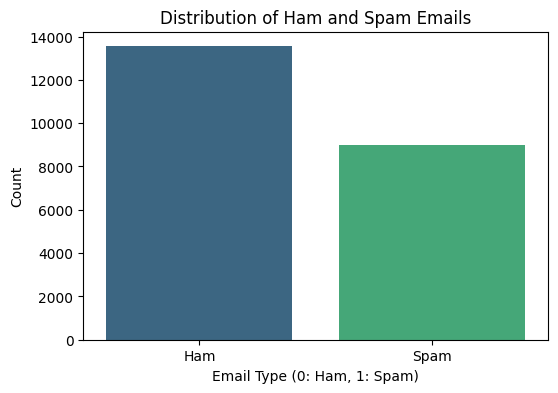

In [ ]:
# Visualize Counts of Spam and Ham Emails
plt.figure(figsize=(6, 4))
sns.countplot(data=emails, x='Label', palette="viridis")
plt.title("Distribution of Ham and Spam Emails")
plt.xlabel("Email Type (0: Ham, 1: Spam)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

In [ ]:
# Data Preprocessing
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in STOP_WORDS])

emails['Cleaned_Message'] = emails['Message'].apply(preprocess_text)
emails['Label'] = emails['Label'].map({'ham': 0, 'spam': 1})

# Print preprocessed data
print("Sample of preprocessed emails:")
print(emails[['Message', 'Cleaned_Message', 'Label']].head())

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    emails['Cleaned_Message'], emails['Label'], test_size=0.2, random_state=42
)

# Print dataset sizes
print(f"\nTraining data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

# Print a sample of training data
print("\nSample training data:")
for i in range(5):
    print(f"Email: {X_train.iloc[i]}")
    print(f"Label: {y_train.iloc[i]}")
    print("---")

Sample of preprocessed emails:
                                             Message  \
0  Subject: ces changes on 16 th & 17 th\ndaren -...   
1  Subject: re :\ni have inputted the spot deals ...   
2  Subject: texaco 989826\nbill moore called this...   
3  Subject: meter 1558\ndaren - meter 1558 has no...   
4  Subject: enron / hpl actuals for october 24 , ...   

                                     Cleaned_Message  Label  
0  ces changes 16 th 17 th daren wanted make sure...      0  
1  inputted spot deals system added sitara ticket...      0  
2  texaco 989826 bill moore called morning said s...      0  
3  meter 1558 daren meter 1558 nom march little f...      0  
4  enron hpl actuals october 24 2000 teco tap 72 ...      0  

Training data size: 18032
Testing data size: 4508

Sample training data:
Email: please respond new hire dinner rsvp needed cool send confirmation next week original message williams iii bill sent wednesday july 25 2001 12 18 pm rodriguez grace please respond 

In [ ]:
# Visualize Most Frequent Words
all_words = ' '.join(emails['Cleaned_Message'])
word_freq = Counter(all_words.split())
most_common_words = word_freq.most_common(20)

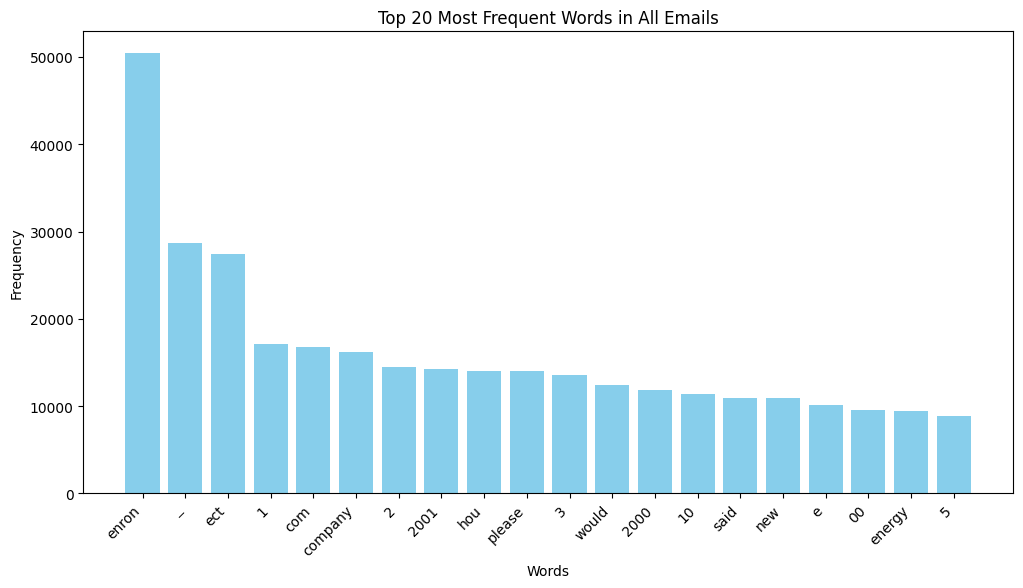

In [ ]:
# Plot Most Frequent Words
words, frequencies = zip(*most_common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words in All Emails')
plt.show()

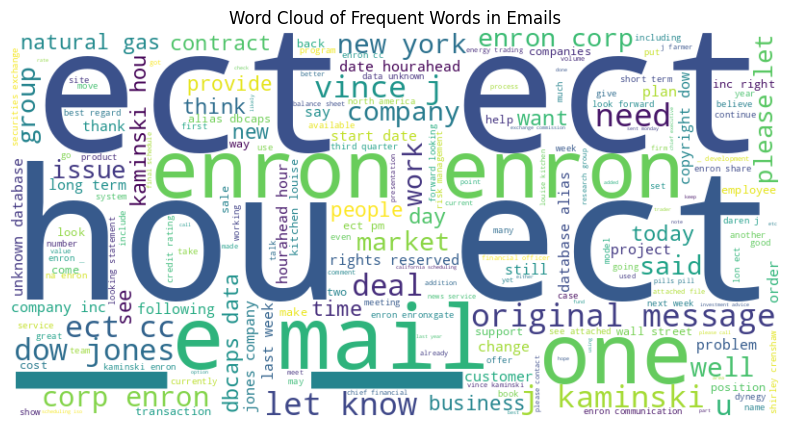

In [ ]:
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Words in Emails')
plt.show()

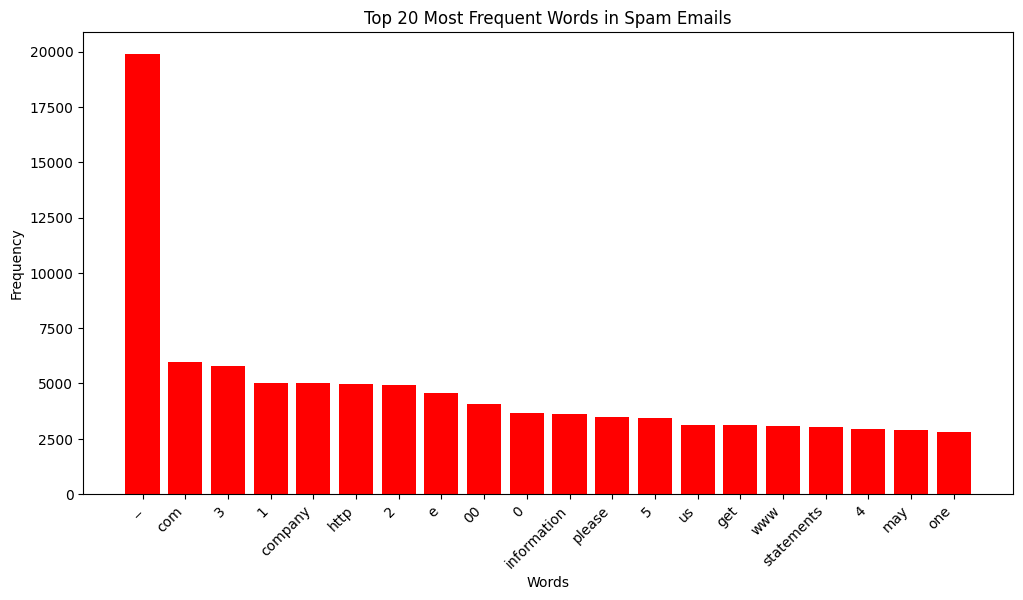

In [ ]:
# Visualize Most Frequent Words for Spam Emails
spam_words = ' '.join(emails[emails['Label'] == 1]['Cleaned_Message'])
spam_word_freq = Counter(spam_words.split())
spam_most_common = spam_word_freq.most_common(20)

# Plot Most Frequent Words in Spam Emails
spam_words, spam_freqs = zip(*spam_most_common)
plt.figure(figsize=(12, 6))
plt.bar(spam_words, spam_freqs, color='red')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words in Spam Emails')
plt.show()

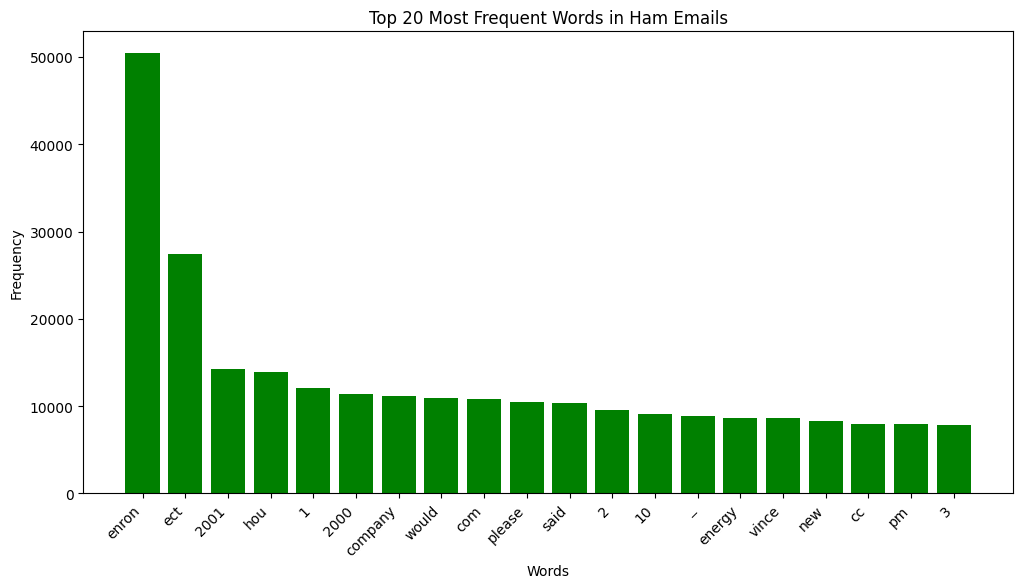

In [ ]:
# Visualize Most Frequent Words for Ham Emails
ham_words = ' '.join(emails[emails['Label'] == 0]['Cleaned_Message'])
ham_word_freq = Counter(ham_words.split())
ham_most_common = ham_word_freq.most_common(20)

# Plot Most Frequent Words in Ham Emails
ham_words, ham_freqs = zip(*ham_most_common)
plt.figure(figsize=(12, 6))
plt.bar(ham_words, ham_freqs, color='green')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words in Ham Emails')
plt.show()

In [ ]:
# Save Visualizations as Files
wordcloud.to_file("wordcloud_all_emails.png")

In [ ]:
print("Unique values in 'Label' column before mapping:")
print(emails['Label'].unique())


Unique values in 'Label' column before mapping:
[0 1]


<ipython-input-15-1361cc075e29>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=emails, x='Label', palette="viridis")


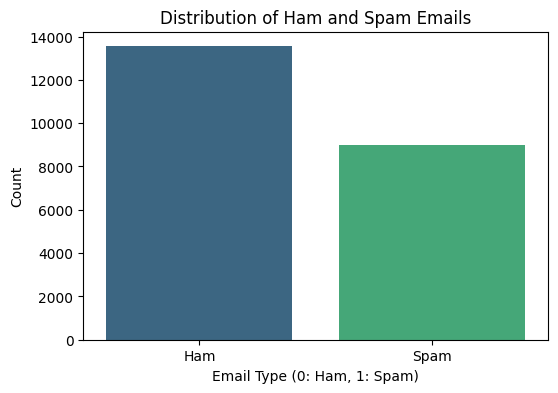

In [ ]:
from collections import Counter
from wordcloud import WordCloud

# Visualize Counts of Spam and Ham Emails
plt.figure(figsize=(6, 4))
sns.countplot(data=emails, x='Label', palette="viridis")
plt.title("Distribution of Ham and Spam Emails")
plt.xlabel("Email Type (0: Ham, 1: Spam)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
# Get the mapping of tokens to IDs
token_to_id = vectorizer.vocabulary_

# Print the token-to-ID mapping
print(token_to_id)


{'please': 3455, 'respond': 3884, 'new': 3094, 'hire': 2233, 'dinner': 1439, 'rsvp': 3978, 'needed': 3075, 'cool': 1184, 'send': 4087, 'confirmation': 1113, 'next': 3104, 'week': 4880, 'original': 3239, 'message': 2919, 'williams': 4917, 'iii': 2316, 'bill': 686, 'sent': 4093, 'wednesday': 4879, 'july': 2550, '25': 91, '2001': 69, '12': 29, '18': 53, 'pm': 3463, 'rodriguez': 3957, 'grace': 2121, 'sounds': 4252, 'great': 2132, '17': 51, '15': 44, 'count': 1218, '11': 25, '14': 40, 'todd': 4589, 'scott': 4040, 'lee': 2655, 'van': 4772, 'john': 2531, 'jill': 2524, 'bruce': 779, 'james': 2507, 'chris': 952, 'warner': 4857, 'darren': 1298, 'steven': 4344, 'sean': 4046, 'david': 1309, 'hall': 2166, 'steve': 4343, 'anderson': 412, 'page': 3278, 'neil': 3083, 'richter': 3931, 'jeff': 2519, 'sheila': 4146, 'elizabeth': 1619, 'belden': 655, 'tim': 4576, 'calger': 811, 'christopher': 958, 'matt': 2863, 'cc': 877, 'attending': 551, 'august': 564, 'lst': 2770, 'let': 2669, 'know': 2588, 'thursday':

In [ ]:
# Print the tokenized vocabulary
print(vectorizer.get_feature_names_out())

['00' '000' '0000' ... 'zone' 'zonedubai' 'zyban']


In [ ]:
# Evaluate Model
y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.9765

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2744
           1       0.97      0.97      0.97      1764

    accuracy                           0.98      4508
   macro avg       0.98      0.98      0.98      4508
weighted avg       0.98      0.98      0.98      4508



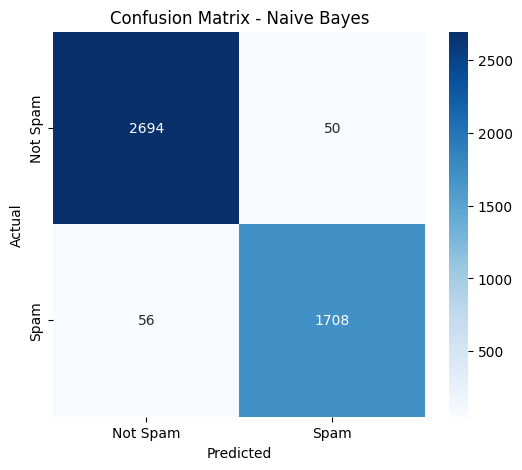

In [ ]:
# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Save Naive Bayes Model
import joblib
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
# Check for GPU Availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


DistilBertTokenizer.from_pretrained(...) - 	Loads a pre-trained tokenizer for tokenizing input text into a format suitable for DistilBERT.
DistilBertForSequenceClassification.from_pretrained(...) - Loads a pre-trained DistilBERT model fine-tuned for classification tasks.


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            padding=True,
            max_length=max_len
        )
        # store labesl
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


# Prepare Data for BERT
train_dataset = EmailDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = EmailDataset(X_test.tolist(), y_test.tolist(), tokenizer)

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from transformers import EarlyStoppingCallback
import numpy as np

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = torch.tensor(predictions).argmax(dim=-1)
    labels = torch.tensor(labels)
    precision, recall, f1, _ = precision_recall_fscore_support(labels.numpy(), predictions.numpy(), average="binary")
    acc = accuracy_score(labels.numpy(), predictions.numpy())
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    greater_is_better=True,
    fp16=False,                                # Whether to use mixed precision training (False in this case)
    #  means the model will use full precision
    # It reduces memory usage and speeds up computations, especially on GPUs that support mixed precision
    dataloader_num_workers=4,
    metric_for_best_model="eval_loss"
)

# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,   # Include tokenizer for logging compatibility
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.058200,0.088243,0.977152,0.993464,0.947846,0.970119
2,0.024500,0.041239,0.988243,0.982516,0.987528,0.985016
3,0.013300,0.043041,0.989796,0.993678,0.980159,0.986872
4,0.015200,0.045570,0.990683,0.994259,0.981859,0.988021


TrainOutput(global_step=2256, training_loss=0.048247767949199424, metrics={'train_runtime': 3457.6097, 'train_samples_per_second': 20.861, 'train_steps_per_second': 0.652, 'total_flos': 9554608530259968.0, 'train_loss': 0.048247767949199424, 'epoch': 4.0})

In [ ]:
eval_results = trainer.evaluate()
print(f"Available metrics: {eval_results.keys()}")


Available metrics: dict_keys(['eval_loss', 'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])


In [ ]:
# Predictions and Evaluation
predictions = trainer.predict(test_dataset)
y_pred_bert = predictions.predictions.argmax(axis=-1)

# Metrics
print(f"BERT Accuracy: {accuracy_score(y_test, y_pred_bert):.4f}")
print("\nBERT Classification Report:\n", classification_report(y_test, y_pred_bert))

BERT Accuracy: 0.9772

BERT Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      2744
           1       0.99      0.95      0.97      1764

    accuracy                           0.98      4508
   macro avg       0.98      0.97      0.98      4508
weighted avg       0.98      0.98      0.98      4508



/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


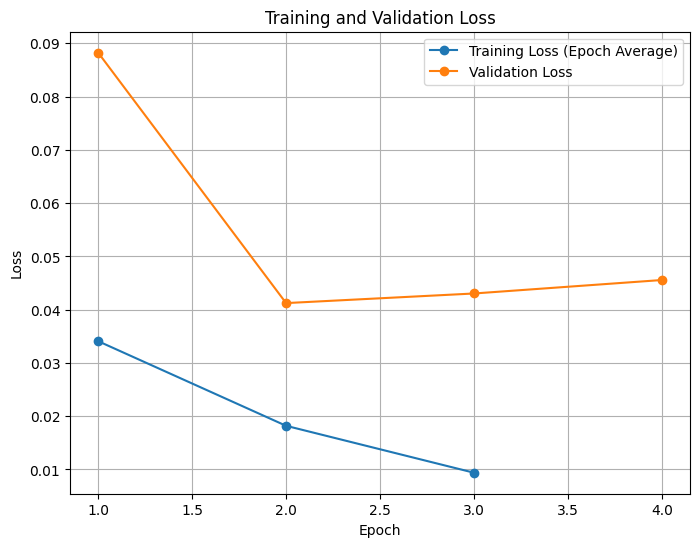

In [ ]:
# Group training loss by epoch
training_logs = trainer.state.log_history
train_loss_per_epoch = defaultdict(list)

for log in training_logs:
    if 'loss' in log and 'epoch' in log:
        train_loss_per_epoch[int(log['epoch'])].append(log['loss'])

# Compute average training loss per epoch
avg_train_loss = [np.mean(train_loss_per_epoch[epoch]) for epoch in range(1, len(train_loss_per_epoch) + 1)]

# Validation loss per epoch
eval_loss = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]

# Ensure lengths match
epochs = list(range(1, min(len(avg_train_loss), len(eval_loss)) + 1))
avg_train_loss = avg_train_loss[:len(epochs)]
eval_loss = eval_loss[:len(epochs)]

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, avg_train_loss, label='Training Loss (Epoch Average)', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

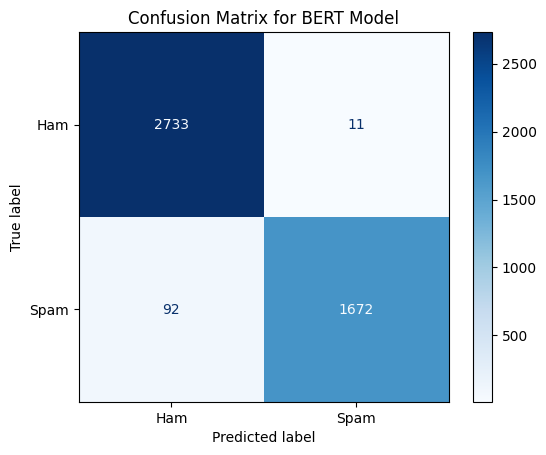

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = predictions.label_ids                    # True labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_bert, labels=[0, 1])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix for BERT Model")
plt.show()

In [ ]:
# Save BERT Model
model.save_pretrained('./bert_saved_model')
tokenizer.save_pretrained('./bert_saved_model')

('./bert_saved_model/tokenizer_config.json',
 './bert_saved_model/special_tokens_map.json',
 './bert_saved_model/vocab.txt',
 './bert_saved_model/added_tokens.json')